In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym

2023-10-19 10:53:47.740459: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-19 10:53:47.740492: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-19 10:53:47.740512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-19 10:53:47.746498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Choose Environment Here
env= gym.make("Pendulum-v1", render_mode='rgb_array')

In [13]:
# Plotting functions
def plot_rewards(rewards_TD3, rewards_DDPG, title, xlabel, ylabel):
    """
    Plot the total reward for each episode.

    Parameters:
    - rewards (list): A list of total rewards, one for each episode.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    """

    plt.figure(figsize=(10, 6))
    plt.plot(rewards_TD3, label="TD3")
    plt.plot(rewards_DDPG, label="DDPG")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [14]:
class ReplayBuffer:
    def __init__(self, max_size=1000000, state_size=1, n_actions=1):
        self.max_size = max_size
        self.is_full = False
        self._mem_length = 0
            
        self._state_buffer = np.zeros((self.max_size, *state_size), dtype=np.float32)
        self._action_buffer = np.zeros((self.max_size, n_actions), dtype=np.float32)
        self._reward_buffer = np.zeros((self.max_size,), dtype=np.float32)
        self._next_state_buffer = np.zeros((self.max_size, *state_size), dtype=np.float32)
        self._done_buffer = np.zeros((self.max_size,), dtype= bool)
        
    def __len__(self):
        return self._mem_length

    def add_exp(self, state, action, reward, next_state, done):
        # Circular buffer (overwrites after it wraps over)
        mem_index = self._mem_length % self.max_size

        self._state_buffer[mem_index] = state
        self._action_buffer[mem_index] = action
        self._reward_buffer[mem_index] = reward
        self._next_state_buffer[mem_index] = next_state
        self._done_buffer[mem_index] = int(done)
                
        self._mem_length += 1
        
        if self._mem_length == self.max_size:
            self.is_full = True

    def sample(self, batch_size):
        if not self.is_full:
            record_range = self._mem_length
        else:
            record_range = self.max_size
        
        batch_indices    = np.random.choice(record_range, batch_size, replace=False)
        
        state_batch         = self._state_buffer[batch_indices]
        action_batch        = self._action_buffer[batch_indices]
        reward_batch        = self._reward_buffer[batch_indices]
        next_state_batch    = self._next_state_buffer[batch_indices]
        done_batch          = self._done_buffer[batch_indices]
        
        state_batch = tf.convert_to_tensor(state_batch, dtype= tf.float32)
        action_batch = tf.convert_to_tensor(action_batch, dtype= tf.float32)
        reward_batch = tf.convert_to_tensor(reward_batch, dtype= tf.float32)
        next_state_batch = tf.convert_to_tensor(next_state_batch, dtype= tf.float32)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

In [15]:
class Critic(tf.keras.Model):
  def __init__(self):
    super(Critic, self).__init__()
    self.f1 = tf.keras.layers.Dense(512, activation='relu')
    self.f2 = tf.keras.layers.Dense(512, activation='relu')
    self.v =  tf.keras.layers.Dense(1, activation=None)

  def call(self, inputstate, action):
    x = self.f1(tf.concat([inputstate, action], axis=1))
    x = self.f2(x)
    x = self.v(x)
    return x


class Actor(tf.keras.Model):
  def __init__(self, no_action):
    super(Actor, self).__init__()    
    self.f1 = tf.keras.layers.Dense(512, activation='relu')
    self.f2 = tf.keras.layers.Dense(512, activation='relu')
    self.mu =  tf.keras.layers.Dense(no_action, activation='tanh')

  def call(self, state):
    x = self.f1(state)
    x = self.f2(x)
    x = self.mu(x)  
    scaled_output = 0.5 * (x + 1.0) * (env.action_space.high - env.action_space.low) + env.action_space.low
    return scaled_output

In [16]:
class TD3_Agent():
    def __init__(self, batch_size=64, gamma=0.99, actor_update_rate=2, warmup=1000, actor_lr=0.001, critic_lr=0.002, 
                 buffer_size=1000000, tau=0.005, actor_noise=0.1, training_noise=0.2,noise_clip=0.5):
        
        self.n_actions = env.action_space.shape[0]
        self.state_size = env.observation_space.shape

        self.actor_main = Actor(self.n_actions)
        self.actor_target = Actor(self.n_actions)
        
        self.critic_main = Critic()
        self.critic_main2 = Critic()
        self.critic_target = Critic()
        self.critic_target2 = Critic()
        
        # Hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma     
        self.actor_update_steps = actor_update_rate
        self.warmup = warmup
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.buffer_size = buffer_size
        self.tau = tau
        self.actor_noise_std = actor_noise
        self.noise_std = training_noise
        self.noise_clip = noise_clip

        # Optimizers
        self.a_opt = tf.keras.optimizers.Adam(self.actor_lr)
        self.c_opt_1 = tf.keras.optimizers.Adam(self.critic_lr)
        self.c_opt_2 = tf.keras.optimizers.Adam(self.critic_lr)
        
        # Replay Buffer
        self.memory = ReplayBuffer(self.buffer_size, self.state_size, self.n_actions)

        # Helper Variables
        self.trainstep = 0
        self.min_action = env.action_space.low[0]
        self.max_action = env.action_space.high[0]
        
        # Compile Networks
        self.actor_target.compile(optimizer=self.a_opt)
        self.critic_target.compile(optimizer=self.c_opt_1)
        self.critic_target2.compile(optimizer=self.c_opt_2)
    

    def act(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)

        actions = self.actor_main(state)
        
        # Add noise to actions if not in warmup
        if self.trainstep > self.warmup:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=self.actor_noise_std)

        # Clip actions within limits
        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))

        return actions[0]


    def add_exp(self, state, action, reward, next_state, done):
        self.memory.add_exp(state, action, reward, next_state, done)

    def update_target(self):
        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights1.append(weight * self.tau + targets1[i]*(1-self.tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights2.append(weight * self.tau + targets2[i]*(1-self.tau))
        self.critic_target.set_weights(weights2)

        weights3 = []
        targets3 = self.critic_target2.weights
        for i, weight in enumerate(self.critic_main2.weights):
            weights3.append(weight * self.tau + targets3[i]*(1-self.tau))
        self.critic_target2.set_weights(weights3)

    def train(self):
        if self.memory._mem_length < self.warmup:
            print("Collected warmup experience {} out of {}".format(self.memory._mem_length, self.warmup))
            return 0

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        with tf.GradientTape() as tape_1, tf.GradientTape() as tape_2:
            target_actions = self.actor_target(next_states)
            noise = tf.random.normal(shape=[*np.shape(target_actions)], mean=0.0, stddev=self.noise_std)
            target_actions += tf.clip_by_value(noise, -self.noise_clip, self.noise_clip)
            target_actions = self.max_action * (tf.clip_by_value(target_actions, self.min_action, self.max_action))
            
            target_next_state_values_1 = tf.squeeze(self.critic_target(next_states, target_actions), 1)
            target_next_state_values_2 = tf.squeeze(self.critic_target2(next_states, target_actions), 1)
            
            critic_value_1 = tf.squeeze(self.critic_main(states, actions), 1)
            critic_value_2 = tf.squeeze(self.critic_main2(states, actions), 1)
            
            next_state_target_value = tf.math.minimum(target_next_state_values_1, target_next_state_values_2)
            
            target_values = rewards + self.gamma * next_state_target_value * (1 - dones)
            critic_loss_1 = tf.keras.losses.MSE(target_values, critic_value_1)
            critic_loss_2 = tf.keras.losses.MSE(target_values, critic_value_2)
            
            td_errors_1 = target_values - critic_value_1
            td_errors_2 = target_values - critic_value_2
            
            avg_td_errors = (td_errors_1 + td_errors_2) / 2.0

        grads_1 = tape_1.gradient(critic_loss_1, self.critic_main.trainable_variables)
        grads_2 = tape_2.gradient(critic_loss_2, self.critic_main2.trainable_variables)
        
        self.c_opt_1.apply_gradients(zip(grads_1, self.critic_main.trainable_variables))
        self.c_opt_2.apply_gradients(zip(grads_2, self.critic_main2.trainable_variables))
        
        self.trainstep +=1
        
        if self.trainstep % self.actor_update_steps == 0:
                
            with tf.GradientTape() as tape_3:
            
                new_policy_actions = self.actor_main(states)
                actor_loss = -self.critic_main(states, new_policy_actions)
                actor_loss = tf.math.reduce_mean(actor_loss)
            
            grads_3 = tape_3.gradient(actor_loss, self.actor_main.trainable_variables)
            self.a_opt.apply_gradients(zip(grads_3, self.actor_main.trainable_variables))

        self.update_target()
        
        return tf.reduce_mean(avg_td_errors).numpy()

In [17]:
class DDPG_Agent():
    def __init__(self, batch_size=64, gamma=0.99, warmup=1000, actor_lr=0.001, critic_lr=0.002, 
                 buffer_size=1000000, tau=0.005, actor_noise=0.1, training_noise=0.2,noise_clip=0.5):
        
        self.n_actions = env.action_space.shape[0]
        self.state_size = env.observation_space.shape

        self.actor_main = Actor(self.n_actions)
        self.actor_target = Actor(self.n_actions)
        
        self.critic_main = Critic()
        self.critic_target = Critic()
        
        # Hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma     
        self.warmup = warmup
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.buffer_size = buffer_size
        self.tau = tau
        self.actor_noise_std = actor_noise
        self.noise_std = training_noise
        self.noise_clip = noise_clip

        # Optimizers
        self.a_opt = tf.keras.optimizers.Adam(self.actor_lr)
        self.c_opt_1 = tf.keras.optimizers.Adam(self.critic_lr)
        
        # Replay Buffer
        self.memory = ReplayBuffer(self.buffer_size, self.state_size, self.n_actions)

        # Helper Variables
        self.trainstep = 0
        self.min_action = env.action_space.low[0]
        self.max_action = env.action_space.high[0]
        
        # Compile Networks
        self.actor_target.compile(optimizer=self.a_opt)
        self.critic_target.compile(optimizer=self.c_opt_1)
    

    def act(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)

        actions = self.actor_main(state)
        
        # Add noise to actions if not in warmup
        if self.trainstep > self.warmup:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=self.actor_noise_std)

        # Clip actions within limits
        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))

        return actions[0]


    def add_exp(self, state, action, reward, next_state, done):
        self.memory.add_exp(state, action, reward, next_state, done)

    def update_target(self):
        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights1.append(weight * self.tau + targets1[i]*(1-self.tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights2.append(weight * self.tau + targets2[i]*(1-self.tau))
        self.critic_target.set_weights(weights2)

    def train(self):
        if self.memory._mem_length < self.warmup:
            print("Collected warmup experience {} out of {}".format(self.memory._mem_length, self.warmup))
            return 0

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        with tf.GradientTape() as tape_1:
            target_actions = self.actor_target(next_states)
            target_next_state_values = tf.squeeze(self.critic_target(next_states, target_actions), 1)
            critic_value = tf.squeeze(self.critic_main(states, actions), 1)
            target_values = rewards + self.gamma * target_next_state_values * (1 - dones)
            critic_loss = tf.keras.losses.MSE(target_values, critic_value)
            
        grads_1 = tape_1.gradient(critic_loss, self.critic_main.trainable_variables)
        self.c_opt_1.apply_gradients(zip(grads_1, self.critic_main.trainable_variables))
            
        with tf.GradientTape() as tape_2:
            new_policy_actions = self.actor_main(states)
            actor_loss = -tf.reduce_mean(self.critic_main(states, new_policy_actions))
        grads_2 = tape_2.gradient(actor_loss, self.actor_main.trainable_variables)
        self.a_opt.apply_gradients(zip(grads_2, self.actor_main.trainable_variables))

        self.update_target()

        return tf.reduce_mean(target_values - critic_value).numpy()

In [18]:
# TD3 Training Block

# Hyperparameters
episodes = 100
batch_size = 64
gamma = 0.99     
actor_update_steps = 2
warmup = 1000
actor_lr = 0.001
critic_lr = 0.002
buffer_size = 1000000
tau = 0.005
actor_noise_std = 0.1
noise_std = 0.2
noise_clip = 0.5

with tf.device('GPU:1'):
    agent = TD3_Agent(batch_size, gamma, actor_update_steps, warmup, actor_lr, critic_lr, buffer_size, tau, actor_noise_std, noise_std, noise_clip)
    ep_reward = []
    running_ep_avg = []
    td_ep_avg = []
    for episode in range(episodes):
        total_reward = 0 
        td = 0
        state, _ = env.reset()
        done = False
        step = 0
        
        while not done:            
            action = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)
            if truncated:
                done = True
            agent.add_exp(state, action, reward, next_state, done)
            td_loc = agent.train()
            td += td_loc
            state = next_state
            total_reward += reward
            step += 1
            
            if done:
                td_ep_avg.append(td/step)
                ep_reward.append(total_reward)
                avg_reward = np.mean(ep_reward[-100:])
                running_ep_avg.append(avg_reward)
                print("total reward after {} steps is {} and avg reward is {}".format(episode, total_reward, avg_reward))

Collected warmup experience 1 out of 1000
Collected warmup experience 2 out of 1000
Collected warmup experience 3 out of 1000
Collected warmup experience 4 out of 1000
Collected warmup experience 5 out of 1000
Collected warmup experience 6 out of 1000
Collected warmup experience 7 out of 1000
Collected warmup experience 8 out of 1000
Collected warmup experience 9 out of 1000
Collected warmup experience 10 out of 1000
Collected warmup experience 11 out of 1000
Collected warmup experience 12 out of 1000
Collected warmup experience 13 out of 1000
Collected warmup experience 14 out of 1000
Collected warmup experience 15 out of 1000
Collected warmup experience 16 out of 1000
Collected warmup experience 17 out of 1000
Collected warmup experience 18 out of 1000
Collected warmup experience 19 out of 1000
Collected warmup experience 20 out of 1000
Collected warmup experience 21 out of 1000
Collected warmup experience 22 out of 1000
Collected warmup experience 23 out of 1000
Collected warmup exp

In [ ]:
# DDPG Training Block

# Hyperparameters
episodes = 100
batch_size = 64
gamma = 0.99     
actor_update_steps = 2
warmup = 1000
actor_lr = 0.001
critic_lr = 0.002
buffer_size = 1000000
tau = 0.005
actor_noise_std = 0.1
noise_std = 0.2
noise_clip = 0.5

with tf.device('GPU:1'):
    agent = DDPG_Agent(batch_size, gamma, warmup, actor_lr, critic_lr, buffer_size, tau, actor_noise_std, noise_std, noise_clip)
    ep_reward_DDPG = []
    running_ep_avg_DDPG = []
    td_ep_avg_DDPG = []
    for episode in range(episodes):
        total_reward = 0 
        td = 0
        state, _ = env.reset()
        done = False
        step = 0
        
        while not done:            
            action = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)
            if truncated:
                done = True
            agent.add_exp(state, action, reward, next_state, done)
            td_loc = agent.train()
            td += td_loc
            state = next_state
            total_reward += reward
            step += 1
            
            if done:
                td_ep_avg_DDPG.append(td/step)
                ep_reward_DDPG.append(total_reward)
                avg_reward = np.mean(ep_reward_DDPG[-100:])
                running_ep_avg_DDPG.append(avg_reward)
                print("total reward after {} steps is {} and avg reward is {}".format(episode, total_reward, avg_reward))

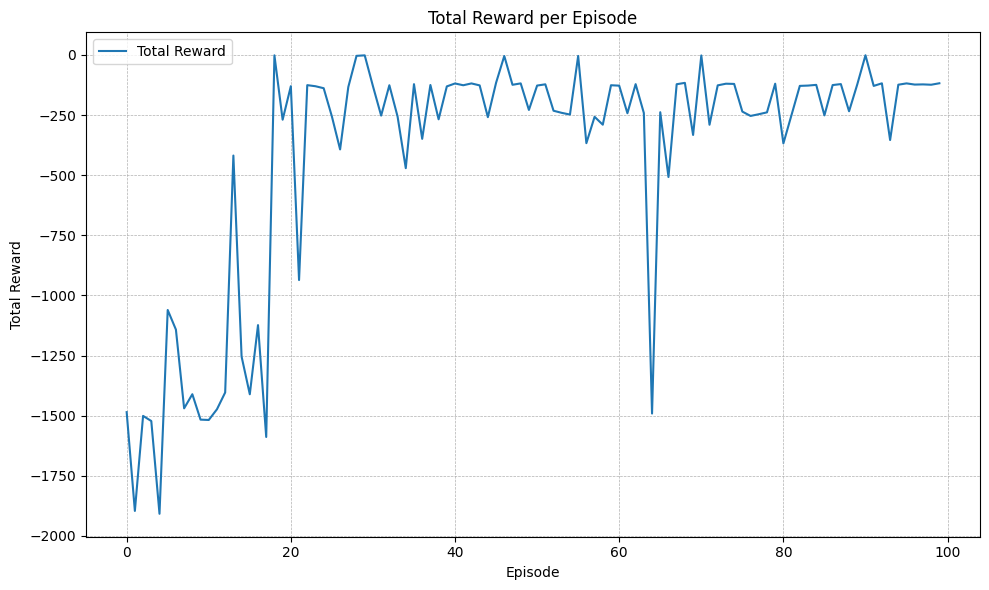

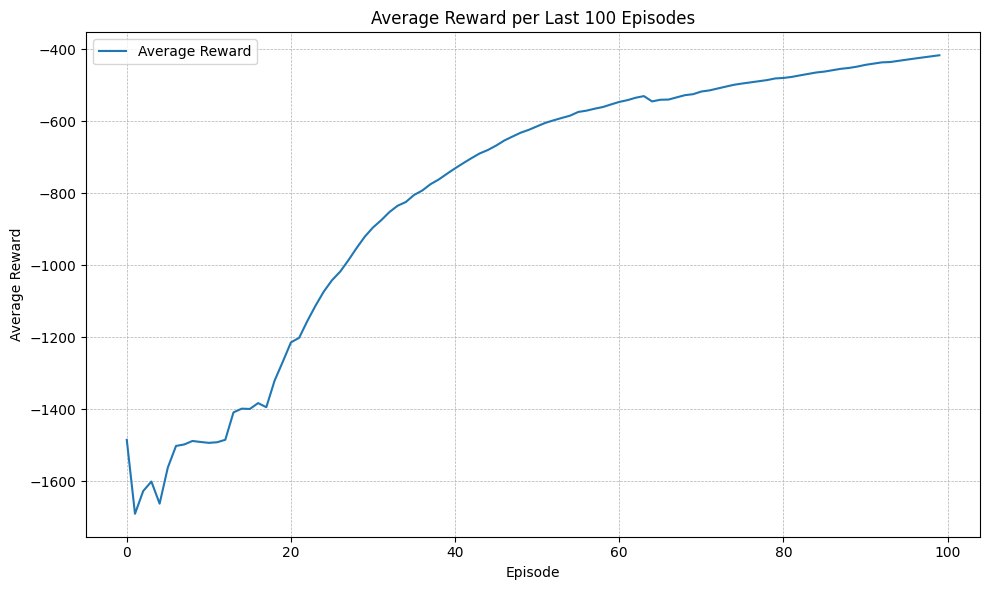

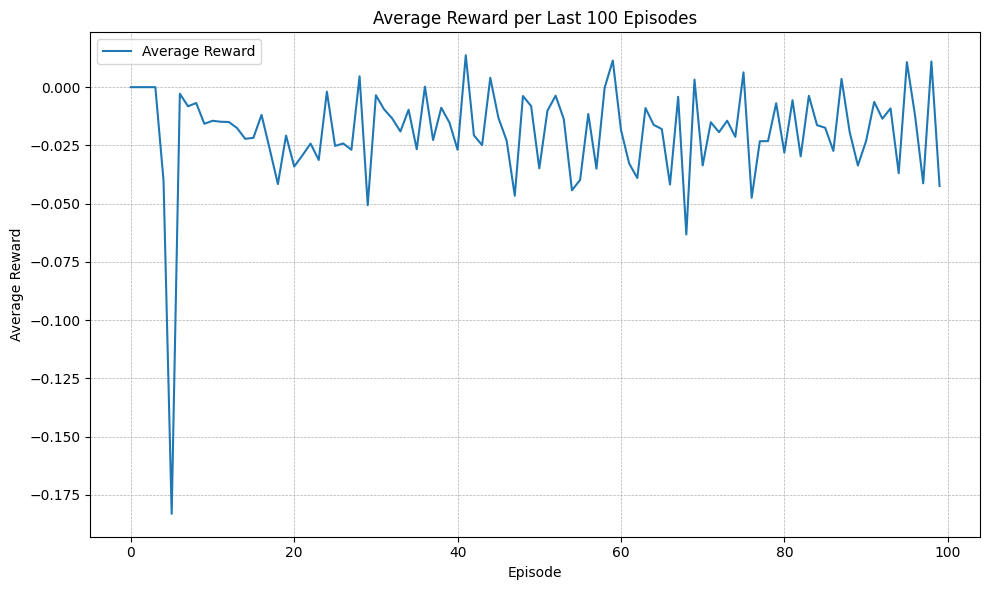

In [ ]:
# Graphing Outcomes
plot_rewards(ep_reward, ep_reward_DDPG, title="Total Reward per Episode", xlabel="Episode", ylabel="Total Reward")

plot_rewards(running_ep_avg, running_ep_avg_DDPG, title="Average Reward per Last 100 Episodes", xlabel="Episode", ylabel="Average Reward")

plot_rewards(td_ep_avg, td_ep_avg_DDPG, title="Average TD Error per Episode", xlabel="Episode", ylabel="Average Error")
